<a href="https://colab.research.google.com/github/julia-lukasiewicz-pater/code-completion-analysis/blob/main/code_completion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Completion Analysis

In this notebook, I present an analysis of the code completion process. The aim of the analysis is to evaluate the quality of the generated code using various metrics and manual inspection.

## Dataset Description

The dataset consists of **45 text files**, each containing code written in Python. These files are short and represent solutions to simple programming tasks. The dataset has been divided into four categories:

- **f_NUMBER.txt**: The code contains a function.
- **fc_NUMBER.txt**: The code contains a function and a comment describing the problem.
- **r_NUMBER.txt**: A raw block of code, with no defined functions or comments.
- **rc_NUMBER.txt**: No function, but there is a comment.

The files are in the format: `<fim_prefix> code <fim_suffix> code <fim_middle>`.

## Code Completion Methods

Model **bigcode/tiny_starcoder_py** was utilized to generate code completions.

## Evaluation Metrics

To assess the quality of the completed code, the following metrics were employed:

- **Exact Match**: The percentage of exact matches between the generated code and the reference code.
- **Edit Distance**: Measures the minimum number of operations (insertions, deletions, substitutions) required to transform one string into another.
- **ROUGE**: A set of metrics for evaluating text generation quality by measuring the overlapping text units, including:
  - **ROUGE-1**: Compares unigrams.
  - **ROUGE-2**: Compares bigrams.
  - **ROUGE-L**: Measures the longest common subsequence.
  - **ROUGE-LSum**: As far as I understand, measures the LCS line by line.
- **ChrF**: A character-based F score.
- **If Compiled**: Checks whether the generated code compiles without errors.
- **Edit Distance on AST Strings**: Measures differences in terms of string edit distance between the abstract syntax trees (AST) of the generated and reference code; however it would be better to calculate distance on trees.
- **Cosine Similarity**: Measures the similarity between the vectors of the generated and reference code, embedded using a pre-trained model **microsoft/graphcodebert-base** with no fine-tuning.
- **Code Semantic Similarity**: Evaluates the semantic similarity of the code, classified by model **claude-3-haiku**.

## Manual Analysis

The generated code completions were also subjected to manual analysis. At the end of the notebook, there is a summary of the conclusions drawn from this analysis, which provides additional insights into the quality and usability of the generated code.

## Installations and imports

In [ ]:
!wget https://github.com/julia-lukasiewicz-pater/code-completion-analysis/raw/refs/heads/main/data/processed/processed_dataset.zip

--2024-10-10 13:44:24--  https://github.com/julia-lukasiewicz-pater/code-completion-analysis/raw/refs/heads/main/data/processed/processed_dataset.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/julia-lukasiewicz-pater/code-completion-analysis/refs/heads/main/data/processed/processed_dataset.zip [following]
--2024-10-10 13:44:25--  https://raw.githubusercontent.com/julia-lukasiewicz-pater/code-completion-analysis/refs/heads/main/data/processed/processed_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18414 (18K) [application/zip]
Saving to: ‘processed_dataset.zip’

processed_datas

In [ ]:
!unzip processed_dataset.zip

Archive:  processed_dataset.zip
   creating: processed_dataset/
  inflating: processed_dataset/f_1.txt  
  inflating: processed_dataset/f_2.txt  
  inflating: processed_dataset/f_3.txt  
  inflating: processed_dataset/f_4.txt  
  inflating: processed_dataset/f_5.txt  
  inflating: processed_dataset/f_6.txt  
  inflating: processed_dataset/f_7.txt  
  inflating: processed_dataset/f_8.txt  
  inflating: processed_dataset/f_9.txt  
  inflating: processed_dataset/f_10.txt  
  inflating: processed_dataset/f_11.txt  
  inflating: processed_dataset/fc_1.txt  
  inflating: processed_dataset/fc_2.txt  
  inflating: processed_dataset/fc_3.txt  
  inflating: processed_dataset/fc_4.txt  
  inflating: processed_dataset/fc_5.txt  
  inflating: processed_dataset/fc_6.txt  
  inflating: processed_dataset/fc_7.txt  
  inflating: processed_dataset/fc_8.txt  
  inflating: processed_dataset/fc_9.txt  
  inflating: processed_dataset/fc_10.txt  
  inflating: processed_dataset/fc_11.txt  
  inflating: proces

In [ ]:
!pip3 install evaluate==0.4.3
!pip3 install rouge_score==0.1.2
!pip3 install sacrebleu==2.4.3
!pip3 install duckduckgo-search==6.3.0
!pip3 install autopep8==2.3.1

In [ ]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import editdistance
from collections import Counter
import tqdm
import pandas as pd
import ast
from evaluate import load
import re
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
from duckduckgo_search import DDGS
import autopep8
import seaborn as sns
import matplotlib.pyplot as plt

## Defining the functions

In [ ]:
def process_text(input_data):
    """
    Process the input data, which can be either a file path or a string of text.

    Args:
        input_data (str): A file path or a string of text.

    Returns:
        str: The processed text.
    """
    if isinstance(input_data, str):
        try:
            with open(input_data, 'r', encoding='utf-8') as file:
                text = file.read()
        except OSError:
            text = input_data
    else:
        raise ValueError("Input must be a file path or a string of text.")
    text = re.sub(r'<\|endoftext\|>', '', text)
    tag_prefix = '<fim_prefix>'
    tag_middle = '<fim_middle>'
    tag_suffix = '<fim_suffix>'

    tag_index_middle = text.find(tag_middle)
    tag_index_prefix = text.find(tag_prefix)
    tag_index_suffix = text.find(tag_suffix)

    text_before_middle = text[:tag_index_middle + len(tag_middle)]
    text_after_middle = text[tag_index_middle + len(tag_middle):]

    text_prefix = text[tag_index_prefix + len(tag_prefix):tag_index_suffix]
    text_suffix = text[tag_index_suffix + len(tag_suffix):tag_index_middle]
    text_middle = text[tag_index_middle + len(tag_middle):]

    reconstructed_text = text_prefix + '\n' + text_middle + '\n' + text_suffix

    output = {
        'text': text,
        'text_before_middle': text_before_middle,
        'text_after_middle': text_after_middle,
        'text_prefix': text_prefix,
        'text_suffix': text_suffix,
        'text_middle': text_middle,
        'reconstructed_text': reconstructed_text
    }

    return output


In [ ]:
def edit_distance(predicted, ground_truth):
  """
  Function to compute the edit distance between predicted and ground truth code snippets.

  Args:
  - predicted (str): The predicted code snippet by the code completion model.
  - ground_truth (str): The ground truth (expected) code snippet.

  Returns:
  - int: The edit distance between the predicted and ground truth code snippets.
  """
  distance = editdistance.eval(predicted, ground_truth)
  return distance

In [ ]:
def datasets_metric(predictions, references, metric_name, **kwargs):
  """
  Function to compute a specific metric from evaluate library between predicted and ground truth code snippets.

  Args:
  - predictions (list): List of predicted code snippets.
  - references (list): List of ground truth (expected) code snippets.
  - metric_name (str): Name of the metric to compute.
  - **kwargs: Additional keyword arguments for the metric function.

  Returns:
  - dict: A dictionary containing the computed metric values.
  """
  metric = load(metric_name)
  results = metric.compute(predictions=predictions,
                       references=references, **kwargs)
  return results

In [ ]:
def ast_evaluate(predictions, references):
  """
  Function to parse the reference and predicted code and calculate the edit distance between the AST strings.
  If the predicted code cannot be parsed, an attempt to fix the code is made.

  Args:
  - predictions (str): The predicted code snippet by the code completion model.
  - references (str): The ground truth (expected) code snippet.

  Returns:
  - int: The edit distance between the predicted and ground truth AST strings.
  """
  try:
    tree_pred = ast.parse(predictions)
    if_compiled = 1
  except SyntaxError:
    try:
      predictions = autopep8.fix_code(predictions)
      tree_pred = ast.parse(predictions)
      if_compiled = 0
    except SyntaxError:

        if_compiled = -1
        distance = None
        return if_compiled, distance


  tree_ref = ast.parse(references)

  tree_pred_dump = ast.dump(tree_pred)
  tree_ref_dump = ast.dump(tree_ref)

  distance = editdistance.eval(tree_pred_dump, tree_ref_dump)

  return if_compiled, distance


In [ ]:
def load_models():
  """
  Function to load the code completion and similarity models.

  Returns:
  - tokenizer_completion: The tokenizer for the code completion model.
  - model_completion: The code completion model.
  - tokenizer_similarity: The tokenizer for the similarity model.
  - model_similarity: The similarity model.
  """
  checkpoint = "bigcode/tiny_starcoder_py"
  device = "cpu"
  tokenizer_completion = AutoTokenizer.from_pretrained(checkpoint)
  model_completion = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

  tokenizer_completion.add_special_tokens({'pad_token': '<PAD>'})
  pad_token_id = tokenizer_completion.pad_token_id

  model_name = "microsoft/graphcodebert-base"
  tokenizer_similarity = RobertaTokenizer.from_pretrained(model_name)
  model_similarity = RobertaModel.from_pretrained(model_name).eval()

  return tokenizer_completion, model_completion, tokenizer_similarity, model_similarity

In [ ]:
def get_code_embedding(code, model, tokenizer):
    """
    Function to get the embedding of a given code snippet.

    Args:
    - code (str): The code snippet to get the embedding for.
    - model: The embedding model.
    - tokenizer: The tokenizer for the embedding model.

    Returns:
    - numpy.ndarray: The embedding of the code snippet.
    """
    inputs = tokenizer(code, return_tensors="pt", padding='max_length', truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state
    code_embedding = embeddings.mean(dim=1).squeeze().numpy()

    return code_embedding

def compute_similarity(code1, code2):
    """
    Function to compute cosine similarity between two code embeddings.

    Args:
        code1 (str): The first code snippet.
        code2 (str): The second code snippet.

    Returns:
        float: The cosine similarity between the two code embeddings.
    """
    embedding1 = get_code_embedding(code1, model_similarity, tokenizer_similarity)
    embedding2 = get_code_embedding(code2, model_similarity, tokenizer_similarity)

    similarity = cosine_similarity([embedding1], [embedding2])[0][0]
    return similarity



In [ ]:
def llm_similarity(code1, code2):
  """
  Function to classify two code snippets based on their similarity using a language model.

  Args:
  - code1 (str): The first code snippet.
  - code2 (str): The second code snippet.

  Returns:
  - str: The classification of the two code snippets.
  """

  prompt_template = """
Given two pieces of Python code, your task is to determine if they are semantically similar.
Output 1 if they are semantically similar, and 0 otherwise. Do not output any explanations.

Example:

Code 1:
def add(a, b):
    return a + b

Code 2:
def sum(x, y):
    return x + y

Output:
1

Your turn:
Code 1:
{code1}

Code 2:
{code2}
"""
  similarity_value = DDGS().chat(prompt_template.format(
                    code1 = code1, code2 = code2),
                    model='claude-3-haiku')
  return similarity_value

## Running the generation and evaluation

Below, models and tokenizers are loaded, and for each file in the dataset, the missing code is generated, evaluated and all the metrics are saved in a csv file.

Wszystkie typy ROUGE, text edit distance, CHRF oraz exact match były obliczane predicted code and their masked reference fragments. Reszta była dla całych tekstów kodu.

In [ ]:
tokenizer_completion, model_completion, tokenizer_similarity, model_similarity = load_models()

In [ ]:
path = 'processed_dataset'
filenames = sorted(os.listdir(path))
metrics = []

device = 'cpu'
for filename in tqdm.tqdm(filenames):
  print(filename)
  processed_texts = process_text(os.path.join(path,filename))
  input_text = processed_texts['text_before_middle']
  inputs = tokenizer_completion(input_text, return_tensors="pt").to(device)
  attention_mask = inputs['attention_mask']
  input_ids = inputs['input_ids']

  outputs = model_completion.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=50, pad_token_id=tokenizer_completion.pad_token_id)
  predicted = tokenizer_completion.decode(outputs[0])


  processed_predicted = process_text(predicted)
  predicted_clean = processed_predicted['text_middle']

  reference_clean = processed_texts['text_middle']

  text_distance = edit_distance(predicted_clean, reference_clean)
  rouge_results = datasets_metric([predicted_clean], [reference_clean], 'rouge')
  rouge1, rouge2, rougeL, rougeLSum = rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL'],rouge_results['rougeLsum']
  chrf_score = datasets_metric([predicted_clean], [reference_clean], 'chrf', **{'whitespace':True, 'char_order':2})['score']
  e_match = datasets_metric([predicted_clean], [reference_clean], 'exact_match')['exact_match']
  if_compiled, ast_distance = ast_evaluate(processed_predicted['reconstructed_text'], processed_texts['reconstructed_text'])
  cos_sim = compute_similarity(processed_predicted['reconstructed_text'], processed_texts['reconstructed_text'])
  llm_sim = llm_similarity(processed_predicted['reconstructed_text'], processed_texts['reconstructed_text'])


  metrics.append((filename, processed_predicted['reconstructed_text'], processed_texts['reconstructed_text'], text_distance, e_match, ast_distance, if_compiled,
                  chrf_score, rouge1, rouge2, rougeL, rougeLSum, cos_sim, llm_sim))




  0%|          | 0/44 [00:00<?, ?it/s]

f_1.txt


  2%|▏         | 1/44 [00:09<06:33,  9.15s/it]

f_10.txt


  5%|▍         | 2/44 [00:18<06:20,  9.06s/it]

f_11.txt


  7%|▋         | 3/44 [00:24<05:23,  7.90s/it]

f_2.txt


  9%|▉         | 4/44 [00:32<05:13,  7.83s/it]

f_3.txt


 11%|█▏        | 5/44 [00:38<04:44,  7.31s/it]

f_4.txt


 14%|█▎        | 6/44 [00:48<05:07,  8.10s/it]

f_5.txt


 16%|█▌        | 7/44 [00:58<05:26,  8.83s/it]

f_6.txt


 18%|█▊        | 8/44 [01:07<05:18,  8.85s/it]

f_7.txt


 20%|██        | 9/44 [01:16<05:13,  8.96s/it]

f_8.txt


 23%|██▎       | 10/44 [01:27<05:19,  9.39s/it]

f_9.txt


 25%|██▌       | 11/44 [01:35<04:56,  8.99s/it]

fc_1.txt


 27%|██▋       | 12/44 [01:44<04:52,  9.15s/it]

fc_10.txt


 30%|██▉       | 13/44 [01:51<04:18,  8.35s/it]

fc_11.txt


 32%|███▏      | 14/44 [02:00<04:19,  8.64s/it]

fc_2.txt


 34%|███▍      | 15/44 [02:09<04:11,  8.68s/it]

fc_3.txt


 36%|███▋      | 16/44 [02:14<03:35,  7.68s/it]

fc_4.txt


 39%|███▊      | 17/44 [02:24<03:43,  8.29s/it]

fc_5.txt


 41%|████      | 18/44 [02:33<03:42,  8.57s/it]

fc_6.txt


 43%|████▎     | 19/44 [02:40<03:22,  8.09s/it]

fc_7.txt


 45%|████▌     | 20/44 [02:51<03:31,  8.81s/it]

fc_8.txt


 48%|████▊     | 21/44 [02:58<03:11,  8.32s/it]

fc_9.txt


 50%|█████     | 22/44 [03:06<03:01,  8.26s/it]

r_1.txt


 52%|█████▏    | 23/44 [03:12<02:38,  7.56s/it]

r_10.txt


 55%|█████▍    | 24/44 [03:20<02:32,  7.64s/it]

r_11.txt


 57%|█████▋    | 25/44 [03:26<02:18,  7.28s/it]

r_2.txt


 59%|█████▉    | 26/44 [03:34<02:13,  7.39s/it]

r_3.txt


 61%|██████▏   | 27/44 [03:42<02:10,  7.70s/it]

r_4.txt


 64%|██████▎   | 28/44 [03:51<02:06,  7.88s/it]

r_5.txt


 66%|██████▌   | 29/44 [04:01<02:08,  8.58s/it]

r_6.txt


 68%|██████▊   | 30/44 [04:06<01:47,  7.70s/it]

r_7.txt


 70%|███████   | 31/44 [04:15<01:42,  7.89s/it]

r_8.txt


 73%|███████▎  | 32/44 [04:22<01:33,  7.77s/it]

r_9.txt


 75%|███████▌  | 33/44 [04:30<01:24,  7.72s/it]

rc_1.txt


 77%|███████▋  | 34/44 [04:39<01:20,  8.05s/it]

rc_10.txt


 80%|███████▉  | 35/44 [04:49<01:18,  8.69s/it]

rc_11.txt


 82%|████████▏ | 36/44 [04:55<01:03,  7.96s/it]

rc_2.txt


 84%|████████▍ | 37/44 [05:02<00:54,  7.77s/it]

rc_3.txt


 86%|████████▋ | 38/44 [05:10<00:47,  7.85s/it]

rc_4.txt


 89%|████████▊ | 39/44 [05:17<00:37,  7.42s/it]

rc_5.txt


 91%|█████████ | 40/44 [05:26<00:31,  7.87s/it]

rc_6.txt


 93%|█████████▎| 41/44 [05:33<00:23,  7.72s/it]

rc_7.txt


 95%|█████████▌| 42/44 [05:41<00:15,  7.87s/it]

rc_8.txt


 98%|█████████▊| 43/44 [05:48<00:07,  7.62s/it]

rc_9.txt


100%|██████████| 44/44 [05:56<00:00,  8.10s/it]


In [ ]:
df = pd.DataFrame(metrics, columns=['filename', 'predicted', 'reference', 'text_distance', 'e_match','ast_distance', 'if_compiled',
                                    'chrf_score', 'rouge1', 'rouge2', 'rougeL', 'rougeLSum', 'cos_sim', 'llm_sim'])
df.to_csv('metrics.csv', index=False)


In [ ]:
#Adding a column that stores information about the category of the reference code, i.e. if it contained functions and comments
df['type'] = df['filename'].str.extract(r'([frc]+)')

## Inspection of the results

In [ ]:
df

,filename,predicted,reference,text_distance,e_match,ast_distance,if_compiled,chrf_score,rouge1,rouge2,rougeL,rougeLSum,cos_sim,llm_sim,type
0,f_1.txt,N = int(input())\n\nrows = []\n\ncols = []\n\n...,N = int(input())\n\nrows = []\n\ncols = []\n\n...,145,0.0,NaN,-1,70.454577,0.468085,0.177778,0.382979,0.382979,0.925359,1,f
1,f_10.txt,"n = int(input())\n\narr = list(map(int, input(...","n = int(input())\n\narr = list(map(int, input(...",67,0.0,335.0,1,72.747340,0.500000,0.111111,0.400000,0.500000,0.855415,1,f
2,f_11.txt,"n = int(input())\n\na = list(map(int,input().s...","n = int(input())\n\na = list(map(int,input().s...",50,0.0,229.0,1,43.888110,0.250000,0.142857,0.250000,0.250000,0.942046,1,f
3,f_2.txt,"s = list(map(int,list(input())))\n\n\n\ndef bi...","s = list(map(int,list(input())))\n\n\n\ndef bi...",47,0.0,195.0,1,69.584872,0.625000,0.285714,0.500000,0.625000,0.862307,1,f
4,f_3.txt,def dec2bin(n):\n\n b = []\n\n while n!= 0:\...,def dec2bin(n):\n\n b = []\n\n while n != 0:...,101,0.0,572.0,1,28.741254,0.160000,0.000000,0.080000,0.160000,0.788178,1,f
5,f_4.txt,b = input()\n\n\n\ndef calculate_negative_and_...,b = input()\n\n\n\ndef calculate_negative_and_...,73,0.0,486.0,0,26.888996,0.171429,0.060606,0.171429,0.171429,0.704633,1,f
6,f_5.txt,import math\n\nn = int(input())\n\n\n\ndef sum...,import math\n\nn = int(input())\n\n\n\ndef sum...,83,0.0,NaN,-1,66.956784,0.484848,0.193548,0.363636,0.484848,0.861852,1,f
7,f_6.txt,"from math import sqrt\n\nn, q = map(int, input...","from math import sqrt\n\nn, q = map(int, input...",89,0.0,485.0,1,69.089514,0.703704,0.461538,0.555556,0.703704,0.931086,1,f
8,f_7.txt,N = int(input())\n\nshift = input()\n\nk = int...,N = int(input())\n\nshift = input()\n\nk = int...,80,0.0,NaN,-1,56.330977,0.500000,0.200000,0.500000,0.500000,0.801844,1,f
9,f_8.txt,"n, k = map(int, input().split())\n\npermutatio...","n, k = map(int, input().split())\n\npermutatio...",192,0.0,NaN,-1,57.327947,0.320000,0.125000,0.320000,0.320000,0.956635,1,f


Let's have a look at the distributions of the matrics for each group.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


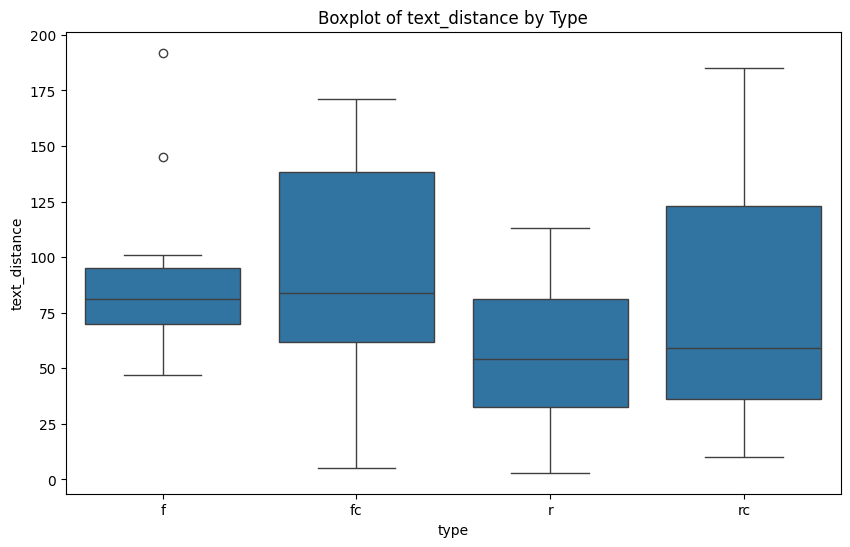

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


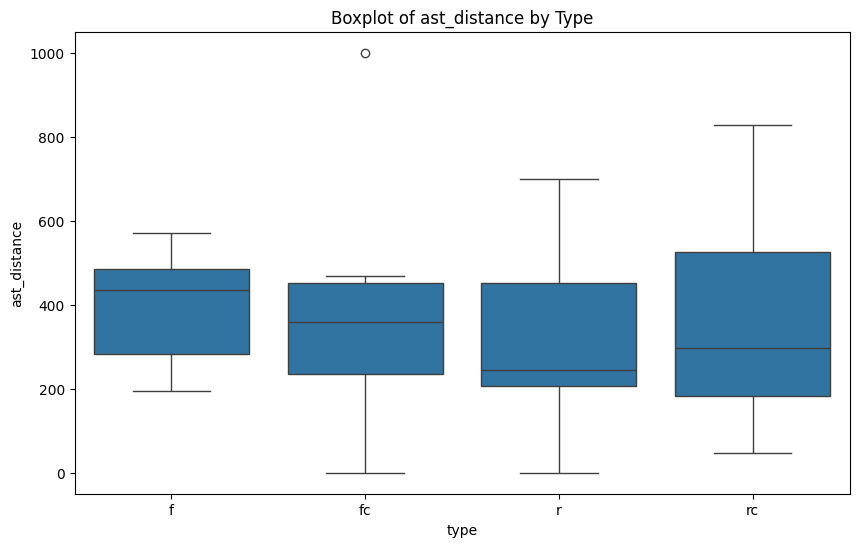

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


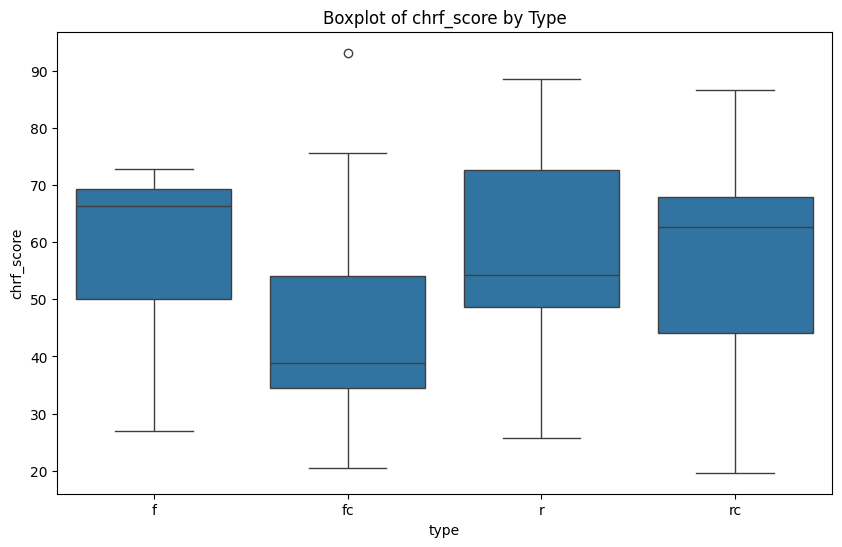

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


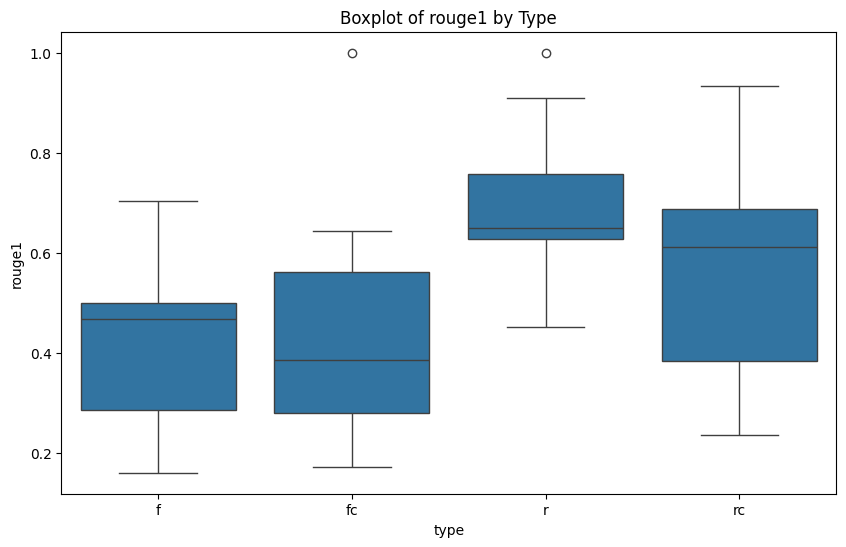

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


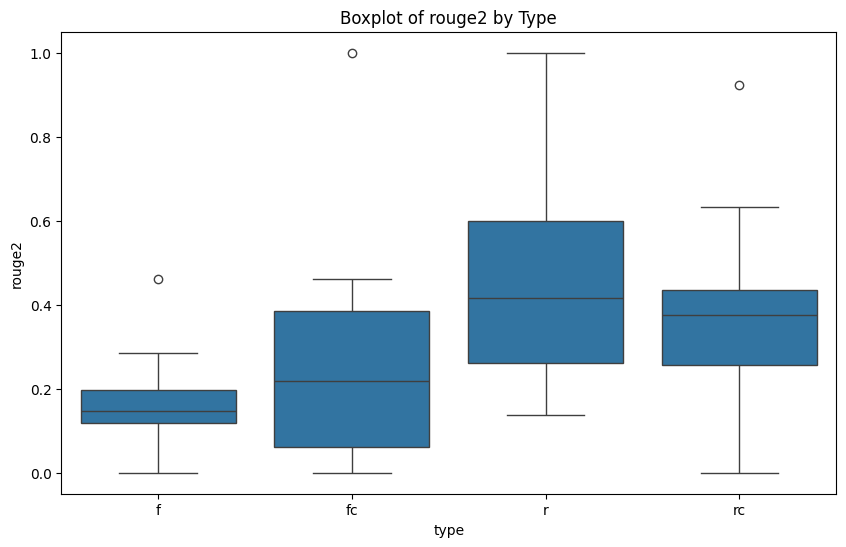

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


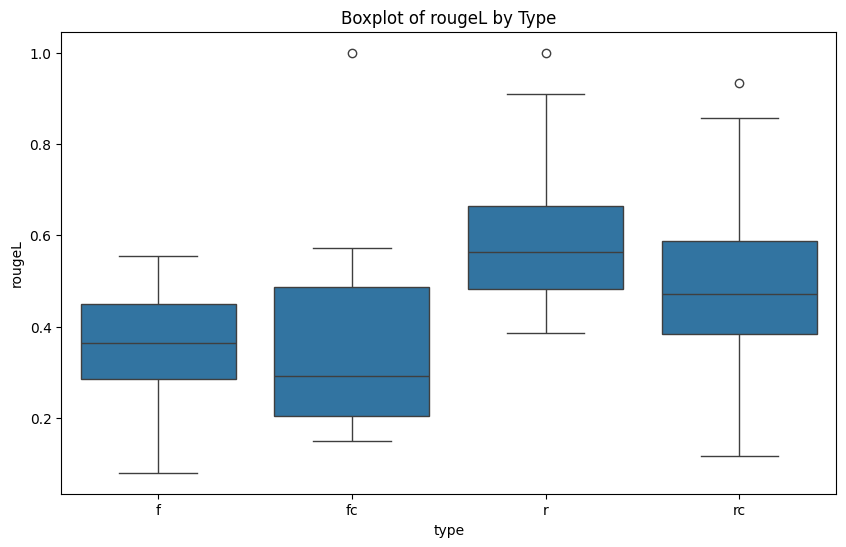

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


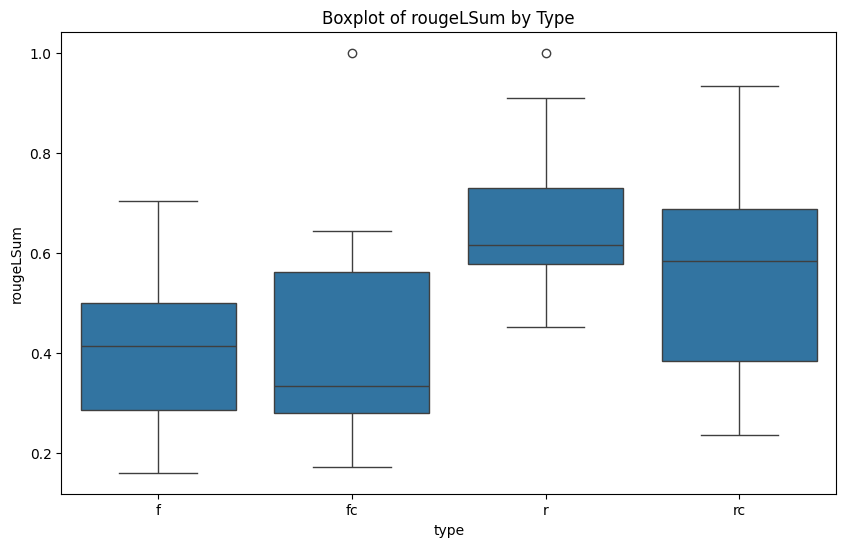

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


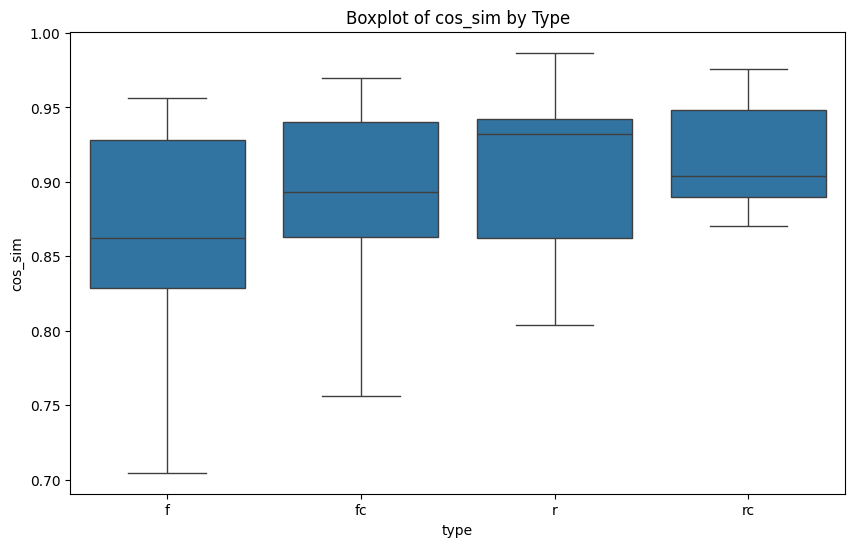

In [ ]:
numerical_columns = ['text_distance', 'ast_distance', 'chrf_score', 'rouge1', 'rouge2', 'rougeL', 'rougeLSum', 'cos_sim']

for column in numerical_columns:
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='type', y=column, data=df)
  plt.title(f'Boxplot of {column} by Type')
  plt.show()


How many pieces of code could be parsed in each group?

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


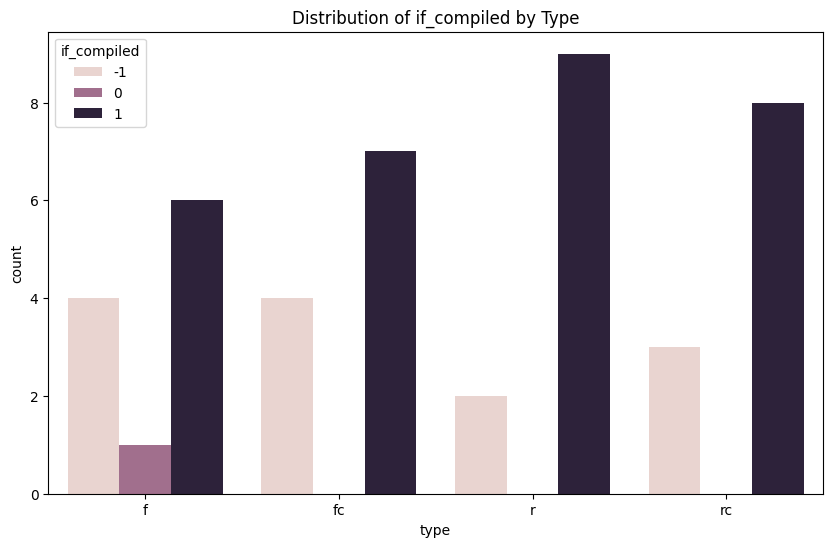

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='if_compiled', data=df)
plt.title('Distribution of if_compiled by Type')
plt.show()


The numerical metrics are mostly correlated.

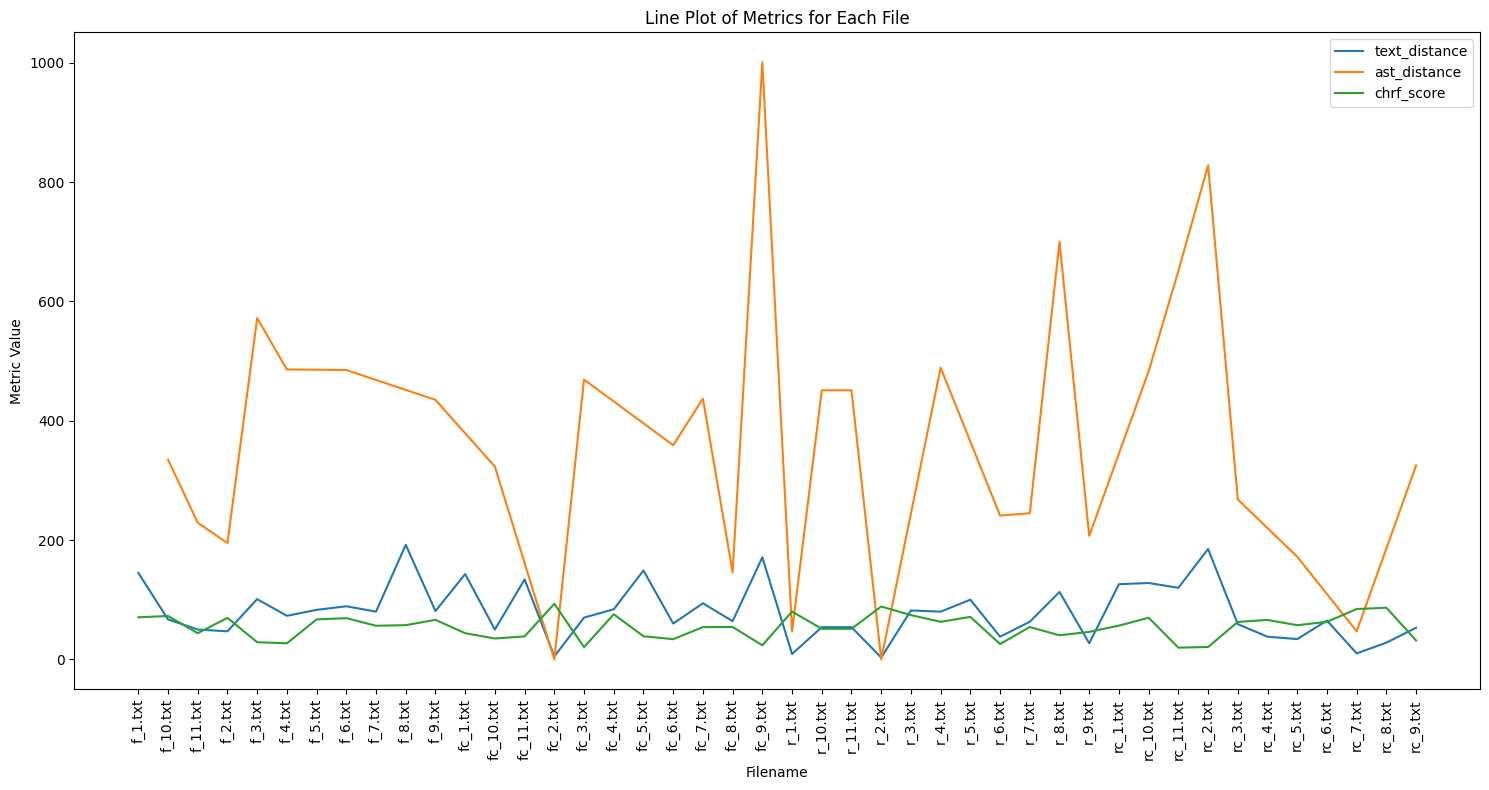

In [ ]:
numerical_columns = ['text_distance', 'ast_distance', 'chrf_score']

plt.figure(figsize=(15, 8))
for column in numerical_columns:
    sns.lineplot(x='filename', y=column, data=df, label=column)

plt.xlabel('Filename')
plt.ylabel('Metric Value')
plt.title('Metrics for Each File')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


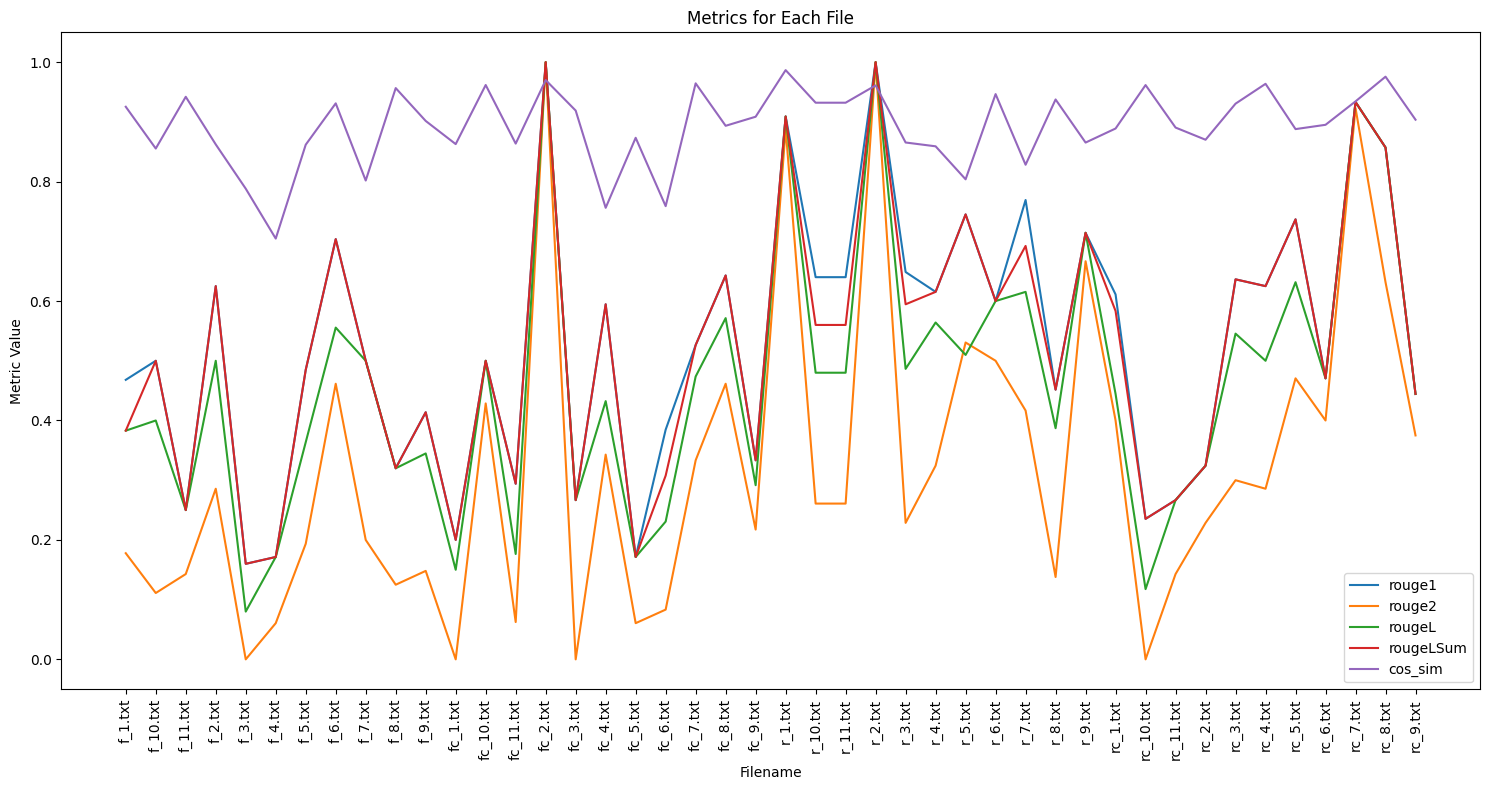

In [ ]:
numerical_columns = ['rouge1', 'rouge2', 'rougeL', 'rougeLSum', 'cos_sim']

plt.figure(figsize=(15, 8))
for column in numerical_columns:
    sns.lineplot(x='filename', y=column, data=df, label=column)

plt.xlabel('Filename')
plt.ylabel('Metric Value')
plt.title('Metrics for Each File')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


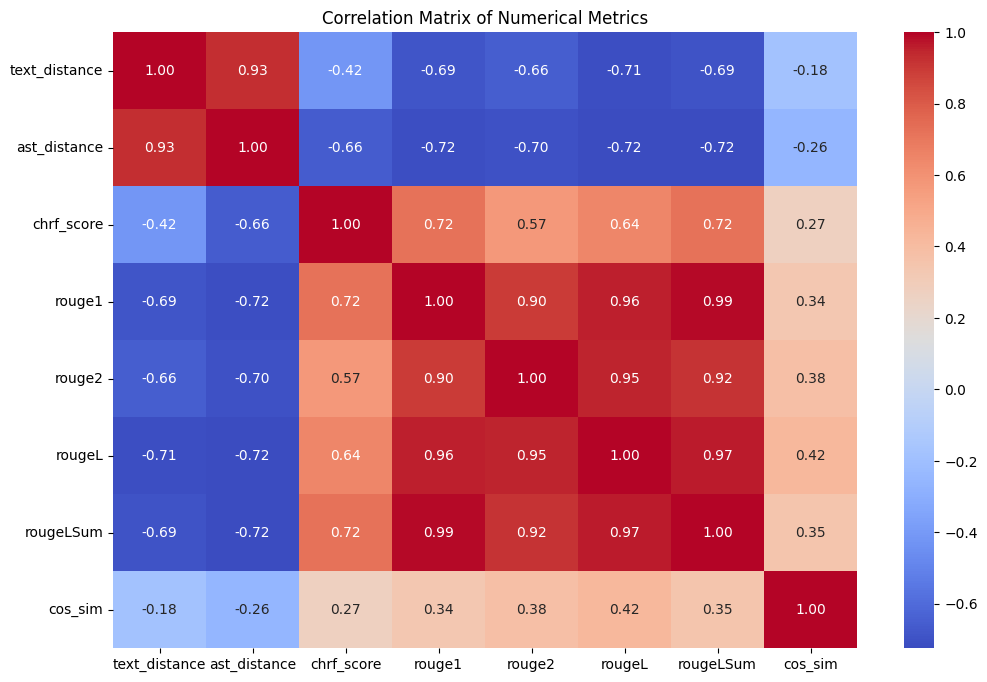

In [ ]:
numerical_columns = ['text_distance', 'ast_distance', 'chrf_score', 'rouge1', 'rouge2', 'rougeL', 'rougeLSum', 'cos_sim']
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Metrics')
plt.show()

# Summary

In my analysis of the code completion task, I observed several important aspects regarding the model's performance, which can be summed up under this:

**The model demonstrates a good understanding of Python syntax, but poor ability to reason.**

1. The generated code fragments are typically syntactically correct. There are instances where the model fails to complete certain constructs or does not add the appropriate indentation. But despite that, the model's suggested next steps are written in correct Python.

2. The model has a limited ability to understand and utilize cues provided in the context.
  2.1. As far as the cues, which can be argued are mainly due to the syntax of Python, e.g. after the `if` keyword, the next line should contain an indentation and some kind of operation, the model handles them very well. It is also worth noting that the model was able to add the `if __name__ == "__main__"` construct in files containing functions, which indicates its familiarity with certain programming conventions.

  2.2. However, when it comes to information derived from function or variable names, or comments, its ability seems limited. E.g. in the case of the code `f_10.txt`, whose context contains a function definition named `prefix_sum`, an auxiliary variable, and a loop definition, the model understands that in the following steps the value under the current index and the auxiliary variable must be summed. However, it adds an unnecessary `if`condition, and simply returns the last value of the auxiliary variable. A common case I observed was similar to this case, i.e. the model seemed to understand what type of operations it needed to perform in the subsequent steps, but their logic was incorrect, which may call into question whether the model actually reasoned and not just predicted syntax.

  2.3. However, there were cases where the model seemed to do better, and these were tasks involving calculations on binary representations. In particular, in two cases the hamming distance had to be computed. The model seemed to know how to do it and suggested the correct steps, despite the fact that in one case it had no cuue in the form of a comment or the name of the function (`r_9.txt`).

  2.4. Sometimes, however, it seemed that the model ignored cues from comments such as in `fc_9.txt`. In this case, the context included the comment saying to find the pair of strings with the smallest hamming distance and a function calculating this metric. However, instead of trying to use it to perform the task, the model simply called the function.

  2.5. My impression is that the less code the model had to generate, the less often it was interrupted without completion.

  2.6. When the model seemed lost, its strategy was usually to call a function, print something out, or enumerate something.


I wonder if a greater number of detailed comments explaining the function's operation and the role of variables could significantly improve the model's results. It is also important to mention that the codes I analyzed were relatively short, consisting of only a few lines, which may have negatively impacted the model's ability to generate more complex solutions.


**Metrics**


The numerical metrics, such as ROUGE, CHRF, edit distance on code strings, and AST strings, seemed to reflect my intuitions about the generated code. For instance, for the code strings where the model somewhat understood what types of operations should be done next — such as summing values or implementing a loop — the ROUGE scores fell in the average range, typically between 30 and 60. Conversely, completely incorrect code strings had ROUGE scores close to 0, while the best ones achieved scores near 1. However, this was primarily in the case of very short and simple code strings where the generated code was identical to the reference. Nevertheless, for comparing limited code fragments that already have some context, and there is little space for variation, this metric proves to be useful.

It became evident that the prompt given to the **claude-3-haiku** language model was overly simplistic. The model often indicated that the code strings were semantically similar, whereas the focus should have been on whether they aimed for the same outcome or performed the same operation. In fact, the only piece of code that was classified as dissimilar was nearly identical to the reference, and reflected that the completion model accurately predicted the subsequent steps. It might be worthwhile to experiment with a prompt that asks for an analysis of whether the code is correct or if it performs the same operation as the reference.

Similarly, cosine similarity did not prove to be useful in this context, as the whole code strings' embeddings were compared, and not only of the masked fragments, leading to artificially inflated scores. It may be necessary to evaluate only the masked parts of the code, although I had the impression that this might not yield favorable results. For such an approach to work effectively, it would probably be better to fine-tune a model for recognizing code clones rather than relying on cosine comparisons of the pretrained vectors alone.

Many of the AI-completed code strings could not be parsed because they were cut off, or there were occasional formatting issues. The more lines of code that needed to be generated, the more likely the model was to stop without finishing, which likely indicates insufficient context. It would be beneficial for the model to update its context as it generates code.

**Are there differences between the types of code?**

It is worth adding a disclaimer here that this dataset is small and may be biased, as sometimes the pieces of code solved very standard problems, while at other times they were quite unconventional, making it difficult to understand their functionality without a description. I wanted to see if I could observe any differences in the completion model performance depending on the presence of various types of cues in the code context, although at this point, I feel that the effects visible between the groups may largely stem from bias in the dataset. For instance, in the "raw" class (no function, no comment), many pieces of code were related to calculations on binary number representations, in which case I had the impression that the model generally works better than in other cases.

For most metrics, their distributions are somewhat similar depending on whether a function or a comment was present in the code or not. For instance, the text edit distance has a lower median for the "raw code" than "function" class, suggesting that in this category, the model generally generated code more similar to the reference. On the other hand, this graph also shows the effect of the presence of comments, as the spread is significantly larger in classes with comments. This may be due to the fact that comments were sometimes helpful, but it could also indicate the presence of bias in the dataset, as comments might have been more frequent in codes performing unconventional tasks.

For edit distance on AST strings, these effects are still somewhat visible, although the distributions across all classes are more similar. The "raw code" class has a greater spread, but the combination of comments and functions can reach quite low values.

In the CHRF metric, the effects are no longer visible, while they are still present in ROUGE. The "raw code" class again is characterised by better outcomes here.

Regarding AST parsing, it was only possible to fix the formatting of the code, which allowed it to be parsed, in the "function" class. Additionally, it shows that the "raw" class performed better, as more pieces of code were successfully parsed compared to the "function" class.

The exact match metric was completely unhelpful, as even where the generated code was identical, the exact match score was 0 due to, for example, extra spaces.